In [37]:
batch_size = 64
ncomps = 500
crop_size = 180

In [38]:

import os
import sys
import random
import numpy as np
import pandas as pd
import torch
from monai.data import DataLoader
from monai.transforms import Compose, NormalizeIntensity, ToTensor
import matplotlib.pyplot as plt
# import config_file as cfg
# from utils import get_model
# from torchsummary import summary

import torchvision.transforms.functional as F

In [39]:
from pathlib import Path

macaw_path = Path(os.getcwd())
sys.path.append(str(macaw_path) +'/')
exp_name = 'moin_bias'

train_csv_path = macaw_path/'splits2/exp199/train.csv'
train_img_path = macaw_path/exp_name/'train'

val_csv_path = macaw_path/'splits2/exp199/val.csv'
val_img_path = macaw_path/exp_name/'val'

test_csv_path = macaw_path/'splits2/exp199/test.csv'
test_img_path = macaw_path/exp_name/'test'

pca_path = macaw_path/exp_name/f'train_hc_pca_{ncomps}.pkl'

train_path = macaw_path/exp_name/f'train_hc_data_PCA_{ncomps}.pkl'
val_path = macaw_path/exp_name/f'val_hc_data_PCA_{ncomps}.pkl'
test_path = macaw_path/exp_name/f'test_hc_data_PCA_{ncomps}.pkl'

In [40]:
home_dir = './'
working_dir = home_dir + exp_name + '/'

df_train = pd.read_csv(train_csv_path)
df_val = pd.read_csv(val_csv_path)

train_fpaths = [os.path.join(working_dir, "train", filename) for filename in df_train['filename']]
train_class_label = df_train['class_label']

val_fpaths = [os.path.join(working_dir, "val", filename) for filename in df_val['filename']]
val_class_label = df_val['class_label']

In [41]:
df_train.head()

,Unnamed: 0,isv_dst,effect_dst,isv_bin,effect_bin,both_bins,bias_label,class_label,strat_col,filepath,filename,morph_bias,intensity_bias
0,21,-0.142174,-1.672015,4,4,4_4,0,0,0_0_4_4,/home/emma/Documents/SBB/datasets/exp199/train...,00000_-0.142_S_-1.672_D_0_B.tiff,1,1
1,196,0.368998,0.985000,5,5,5_5,0,1,1_0_5_5,/home/emma/Documents/SBB/datasets/exp199/train...,00001_0.369_S_0.985_D_0_B.tiff,1,1
2,79,-0.814765,0.639392,3,4,3_4,0,1,1_0_4_3,/home/emma/Documents/SBB/datasets/exp199/train...,00002_-0.815_S_0.639_D_0_B.tiff,1,1
3,581,0.777517,1.606892,6,6,6_6,0,1,1_0_6_6,/home/emma/Documents/SBB/datasets/exp199/train...,00003_0.778_S_1.607_D_0_B.tiff,1,1
4,100,-1.026382,0.278684,3,4,3_4,0,1,1_0_4_3,/home/emma/Documents/SBB/datasets/exp199/train...,00004_-1.026_S_0.279_D_0_B.tiff,1,1


In [42]:
df_val.head()

,Unnamed: 0,isv_dst,effect_dst,isv_bin,effect_bin,both_bins,bias_label,class_label,strat_col,filepath,filename,morph_bias,intensity_bias
0,193,-0.151718,1.506382,4,5,4_5,0,1,1_0_5_4,/home/emma/Documents/SBB/datasets/exp199/val/0...,00000_-0.152_S_1.506_D_0_B.tiff,1,1
1,7,0.880328,0.215220,6,3,6_3,0,1,1_0_3_6,/home/emma/Documents/SBB/datasets/exp199/val/0...,00001_0.88_S_0.215_D_0_B.tiff,1,1
2,385,-1.176568,0.622848,3,4,3_4,0,1,1_0_4_3,/home/emma/Documents/SBB/datasets/exp199/val/0...,00002_-1.177_S_0.623_D_0_B.tiff,1,1
3,98,0.372082,0.535755,5,4,5_4,0,1,1_0_4_5,/home/emma/Documents/SBB/datasets/exp199/val/0...,00003_0.372_S_0.536_D_0_B.tiff,1,1
4,130,0.707394,1.722209,6,6,6_6,0,1,1_0_6_6,/home/emma/Documents/SBB/datasets/exp199/val/0...,00004_0.707_S_1.722_D_0_B.tiff,1,1


In [43]:
# Set bias to zero in csv for no_bias experiments
if exp_name=='no_bias': 
    df_train['bias_label'].values[:]=0
    df_val['bias_label'].values[:]=0
    
print(df_train.bias_label.mean())
df_val.bias_label.mean()

0.8846466287571081


0.8583333333333333

In [44]:
def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

In [45]:
seed = 1  # You can use any integer as the seed
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(seed)
np.random.seed(seed)

g = torch.Generator()
g.manual_seed(seed)

In [46]:
from utils.datasets import EmmaDataset
from monai.data import pad_list_data_collate
from torchvision.transforms import CenterCrop
from utils.customTransforms import ToFloatUKBB

# Define transforms
transforms = Compose([ToTensor(),CenterCrop(crop_size),ToFloatUKBB()])
# train_dataset = UKBBT1Dataset(train_csv_path, train_img_path, transforms.Compose([ToFloatUKBB(),ToTensor(), CenterCrop(crop_size)]))

# create a training data loader - include padding
# train_ds = ImageDataset(image_files=train_fpaths, labels=train_class_label, transform=transforms, reader="ITKReader")
train_ds = EmmaDataset(train_csv_path, train_img_path, exp_name=='no_bias',transforms)
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=0,worker_init_fn=seed_worker, generator=g, pin_memory=torch.cuda.is_available(), collate_fn=pad_list_data_collate)

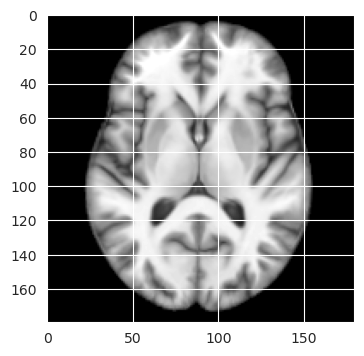

In [47]:
plt.imshow(next(iter(train_loader))[2][1], cmap='gray')

In [48]:
imgs = np.concatenate([d[2].numpy() for d in train_loader],axis=0)
imgs = imgs.reshape(imgs.shape[0],-1)
imgs_dim = imgs.shape[1]

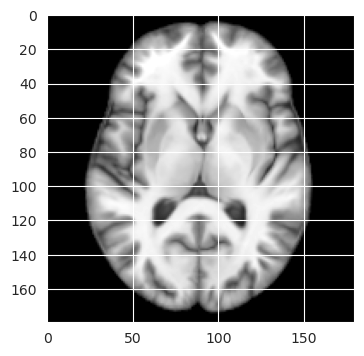

In [49]:
plt.imshow(imgs[0].reshape(crop_size,crop_size), cmap='gray')

## Dimensionality reduction

In [50]:
import pickle
from sklearn.decomposition import PCA

# if os.path.exists(pca_path):
#     with open(pca_path, 'rb') as f:
#         pca = pickle.load(f)
# else:
pca = PCA(n_components=ncomps)
pca.fit(imgs)

with open(pca_path, 'wb') as f:
    pickle.dump(pca, f)

In [51]:
# Initialize lists to collect data
imgs_list = []
disease_list = []
bias_list = []
train_img_names_list=[]

# Process each batch in the test_loader
for d in train_loader:
    disease_list.append(d[0].numpy())
    bias_list.append(d[1].numpy())
    imgs_list.append(d[2].numpy())
    train_img_names_list.append(d[3])

# Concatenate collected data after the loop
imgs = np.concatenate(imgs_list, axis=0)
imgs = imgs.reshape(imgs.shape[0], -1)
imgs_dim = imgs.shape[1]

train_img_names = np.concatenate(train_img_names_list, axis=0)

disease = np.concatenate(disease_list, axis=0)
bias = np.concatenate(bias_list, axis=0)

encoded_data = pca.transform(imgs)

In [52]:
with open(train_path, 'wb') as f:
    pickle.dump({'imgs':imgs, 'disease':disease,'bias':bias, 'pca':pca,'encoded_data':encoded_data, 'img_names':train_img_names}, f)

In [53]:
val_ds = EmmaDataset(val_csv_path, val_img_path, exp_name=='no_bias',transforms)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=True, num_workers=0,worker_init_fn=seed_worker, generator=g, pin_memory=torch.cuda.is_available(), collate_fn=pad_list_data_collate)

In [54]:
# Initialize lists to collect data
imgs_list = []
disease_list = []
bias_list = []

# Process each batch in the test_loader
for d in train_loader:
    disease_list.append(d[0].numpy())
    bias_list.append(d[1].numpy())
    imgs_list.append(d[2].numpy())

# Concatenate collected data after the loop
imgs = np.concatenate(imgs_list, axis=0)
imgs = imgs.reshape(imgs.shape[0], -1)
imgs_dim = imgs.shape[1]

disease = np.concatenate(disease_list, axis=0)
bias = np.concatenate(bias_list, axis=0)
encoded_data = pca.transform(imgs)

In [55]:
with open(val_path, 'wb') as f:
    pickle.dump({'imgs':imgs, 'disease':disease,'bias':bias, 'pca':pca,'encoded_data':encoded_data}, f)

In [56]:
test_ds = EmmaDataset(test_csv_path, test_img_path, exp_name=='no_bias', transforms)
test_loader = DataLoader(test_ds, batch_size=batch_size, shuffle=False, num_workers=0, worker_init_fn=seed_worker, generator=g, pin_memory=torch.cuda.is_available(), collate_fn=pad_list_data_collate)

In [57]:
test_ds.df.loc[test_ds.df['filename']=='00176_0.26_S_-0.941_D_1.539_B.tiff']

,Unnamed: 0,isv_dst,effect_dst,isv_bin,effect_bin,both_bins,bias_label,class_label,strat_col,filepath,filename,morph_bias,intensity_bias


In [58]:
# found = False
# 
# j=0
# 
# while not found:
#     d,b,img,names=next(iter(test_loader))
#     j+=1
#     
#     for i in range(len(d)):
#         # print(names[i])
#         if names[i] == '00176_0.26_S_-0.941_D_1.539_B.tiff':
#             found = True
#             print(d[i].item())
#             print(b[i].item())
#             print(i,j)

In [59]:
d,b,img,names = next(iter(test_loader))

In [60]:
test_ds.df.isna().sum()

Unnamed: 0        0
isv_dst           0
effect_dst        0
isv_bin           0
effect_bin        0
both_bins         0
bias_label        0
class_label       0
strat_col         0
filepath          0
filename          0
morph_bias        0
intensity_bias    0
dtype: int64

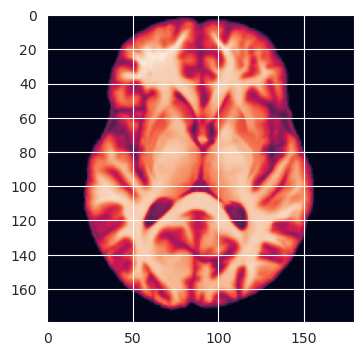

In [61]:
plt.imshow(next(iter(train_loader))[2][1])

In [62]:
test_imgs = np.concatenate([d[2].numpy() for d in test_loader],axis=0)
test_imgs = test_imgs.reshape(test_imgs.shape[0],-1)
test_imgs_dim = test_imgs.shape[1]

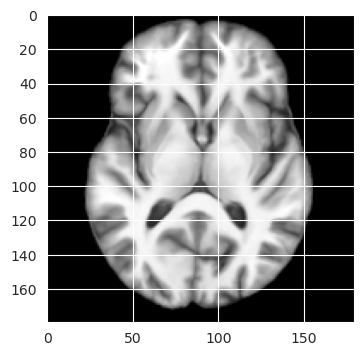

In [63]:
plt.imshow(test_imgs[1].reshape(crop_size,crop_size), cmap='gray')

In [64]:
sample_imgs = test_imgs[:5,:]
t = pca.transform(sample_imgs)
X_recon = pca.inverse_transform(t)

Disease: [1 1 0 1 1]
Bias: [0 1 0 1 1]


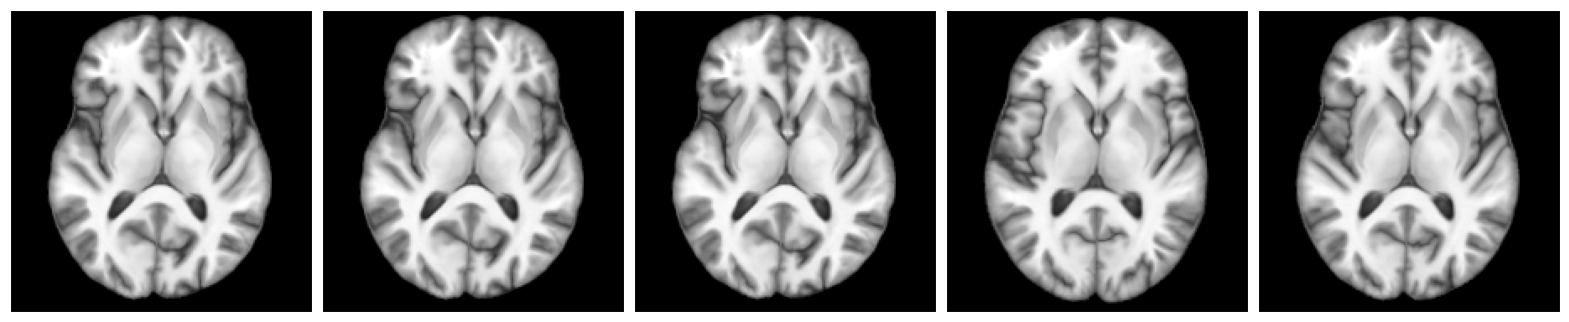

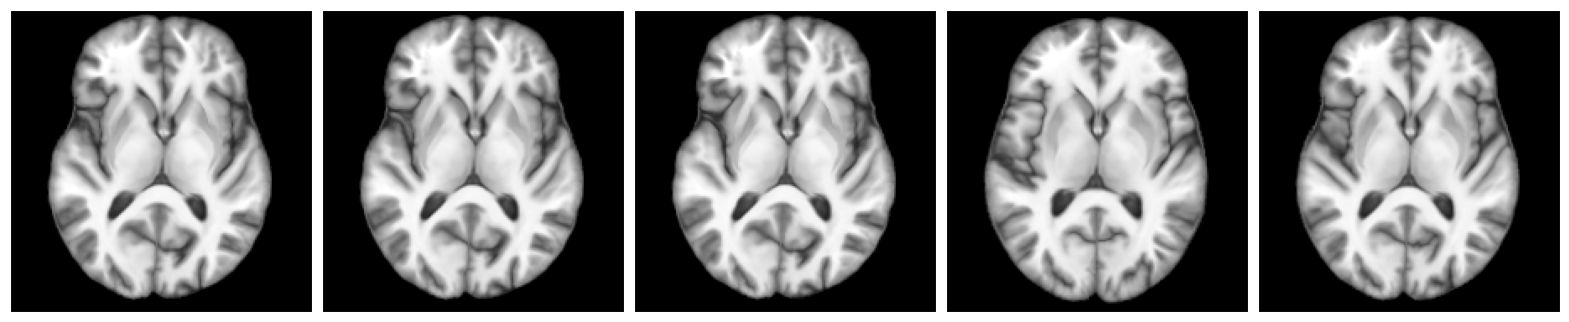

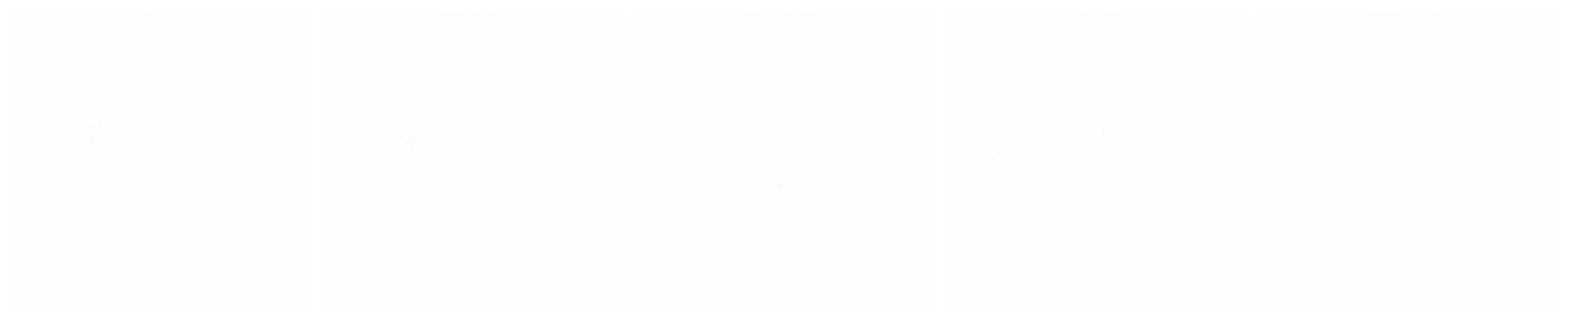

In [65]:
import utils.visualize as vis
print("Disease:", disease[:5])
print("Bias:",bias[:5])

plt.rcParams["figure.figsize"] = 20,5

diff = sample_imgs - X_recon
rr = X_recon + diff
fig = vis.img_grid([d.reshape(crop_size,crop_size) for d in sample_imgs], clim=(0,1), cols=5)
fig = vis.img_grid([d.reshape(crop_size,crop_size) for d in X_recon], clim=(0,1), cols=5)
fig = vis.img_grid([d.reshape(crop_size,crop_size) for d in diff],clim=(-.5,.5),cols=5, cmap='seismic')

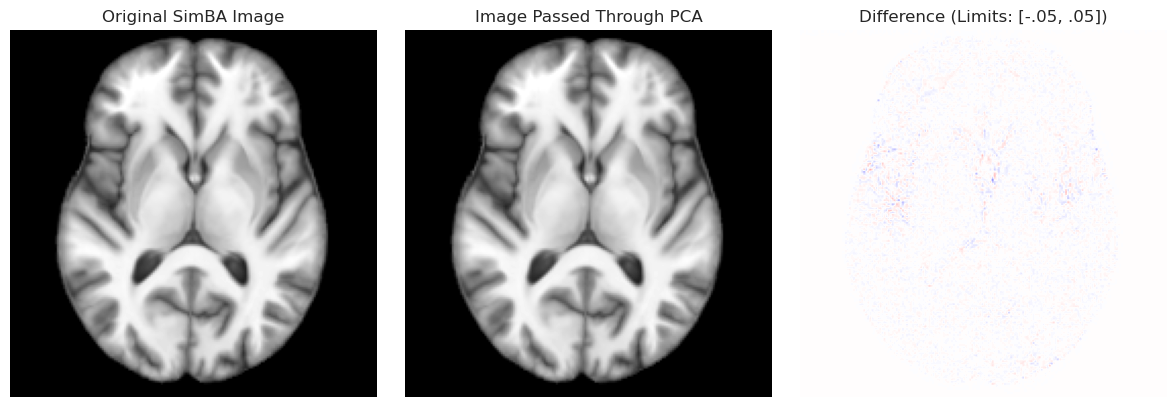

Disease: [1 1 0 1 1]
Bias: [0 1 0 1 1]


In [66]:
import utils.visualize as vis
import matplotlib.pyplot as plt

# Assuming the sample index to display is 0
sample_idx = 4

# Extract the sample and its reconstructed image, difference, and re-encoded image
original_img = sample_imgs[sample_idx].reshape(crop_size, crop_size)
recon_img = X_recon[sample_idx].reshape(crop_size, crop_size)
diff_img = diff[sample_idx].reshape(crop_size, crop_size)

# Set the figure size to accommodate one row and three columns
plt.rcParams["figure.figsize"] = 12, 4

# Plotting the original, reconstructed, and difference images
fig, axes = plt.subplots(1, 3)

# Original Image
axes[0].imshow(original_img, cmap='gray', clim=(0, 1))
axes[0].set_title("Original SimBA Image")
axes[0].axis('off')

# Reconstructed Image
axes[1].imshow(recon_img, cmap='gray', clim=(0, 1))
axes[1].set_title("Image Passed Through PCA")
axes[1].axis('off')

# Difference Image
axes[2].imshow(diff_img, cmap='seismic', clim=(-.05, .05))
axes[2].set_title("Difference (Limits: [-.05, .05])")
axes[2].axis('off')

plt.tight_layout()
plt.show()

print("Disease:", disease[:5])
print("Bias:", bias[:5])


In [67]:
max(diff[1])

0.0112755895

In [68]:
# Initialize lists to collect data
test_imgs_list = []
test_img_names_list = []
disease_list = []
bias_list = []

# Process each batch in the test_loader
for d in test_loader:
    disease_list.append(d[0].numpy())
    bias_list.append(d[1].numpy())
    test_imgs_list.append(d[2].numpy())
    test_img_names_list.append(d[3])
    
# Concatenate collected data after the loop
test_imgs = np.concatenate(test_imgs_list, axis=0)
test_imgs = test_imgs.reshape(test_imgs.shape[0], -1)
test_imgs_dim = test_imgs.shape[1]

test_img_names = np.concatenate(test_img_names_list, axis=0)

disease = np.concatenate(disease_list, axis=0)
bias = np.concatenate(bias_list, axis=0)

encoded_data = pca.transform(test_imgs)

In [69]:
np.max(X_recon)

1.0032278

In [70]:
with open(test_path, 'wb') as f:
    pickle.dump({'imgs':test_imgs, 'disease':disease,'bias':bias, 'pca':pca,'encoded_data':encoded_data, 'img_names':test_img_names}, f)